In [1]:
from UTILITY_quickstart import *
import yaml

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',
    inputBeamFilePathSuffix = '/beams/2024-10-14_Impact_TwoBunch/2024-10-14_TwoBunch.h5',

    csrTF = True,
    numMacroParticles=1e5,
    #loadDefaultLatticeTF=False,
)



#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 100000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting


In [3]:
trackBeam(tao, centerBC14 = True, centerBC20 = True, verbose = True)

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Tracking!
trackBeam() exiting


In [4]:
savedData = {}

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)


for PActiveStr in ["PDrive", "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    #savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    #savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    #savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
    savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)

    savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
    savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
    
    savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

savedData["transverseCentroidOffset"] = np.sqrt(
        (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
        (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
    )


#savedData["lostChargeFraction"] = 1 - (tao.bunch_params("DTOTR")['n_particle_live'] / tao.bunch_params("BEGBC20")['n_particle_live'])
savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

In [5]:
savedData

{'PDrive_mean_x': -4.6267037080429055e-05,
 'PDrive_mean_y': 1.3080805287842841e-08,
 'PDrive_sigma_x': 4.509087279533369e-05,
 'PDrive_sigma_y': 1.614360438864682e-05,
 'PDrive_mean_xp': -5.5003936700922165e-05,
 'PDrive_mean_yp': -9.760755523926104e-08,
 'PDrive_median_x': -3.387351564603983e-05,
 'PDrive_median_y': 2.692853095482324e-08,
 'PDrive_median_xp': -5.2496730540099585e-05,
 'PDrive_median_yp': -7.54549442011765e-09,
 'PDrive_sigmaSI90_x': 4.458714277410812e-05,
 'PDrive_sigmaSI90_y': 1.7390749142432703e-05,
 'PDrive_emitSI90_x': 4.255804560723458e-05,
 'PDrive_emitSI90_y': 5.580347652961183e-06,
 'PDrive_zLen': 8.124769269588217e-05,
 'PDrive_zCentroid': 991.3317162649597,
 'PWitness_mean_x': -0.00011006915919827145,
 'PWitness_mean_y': 1.508534085016587e-07,
 'PWitness_sigma_x': 4.3809395818397454e-05,
 'PWitness_sigma_y': 1.4553543661117392e-05,
 'PWitness_mean_xp': -0.00011925141472779425,
 'PWitness_mean_yp': -1.9685064184037274e-07,
 'PWitness_median_x': -0.0001183360

In [6]:
print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g}, {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g}, {1e6 * savedData["PDrive_zLen"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g}, {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g}, {1e6 * savedData["PWitness_zLen"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g}, {1e6 * PWitness["sigma_y"] :.3g}, {1e6 * PWitness["sigma_z"] :.3g} um""")

Bunch spacing: 		158 um
Transverse offset: 	84.5 um
Angular misalignment: 	0.0617 mrad

Emittances and sigmas - implied by 90% charge
Driver emittance: 	42.6 × 5.58 um-rad
Witness emittance: 	19.6 × 3.3 um-rad
Driver sigma_x,y,z: 	44.6, 17.4, 81.2 um
Witness sigma_x,y,z: 	33.5, 16, 30.6 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	50 × 6.48 um-rad
Witness emittance: 	25 × 4.35 um-rad
Driver sigma_x,y,z: 	45.1, 16.1, 103 um
Witness sigma_x,y,z: 	43.8, 14.6, 51.3 um


Drive:


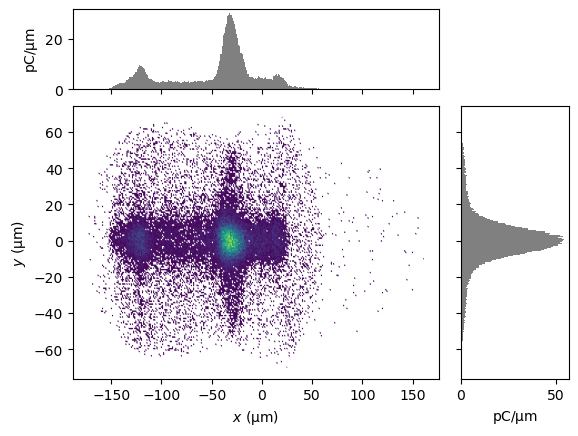

Witness:


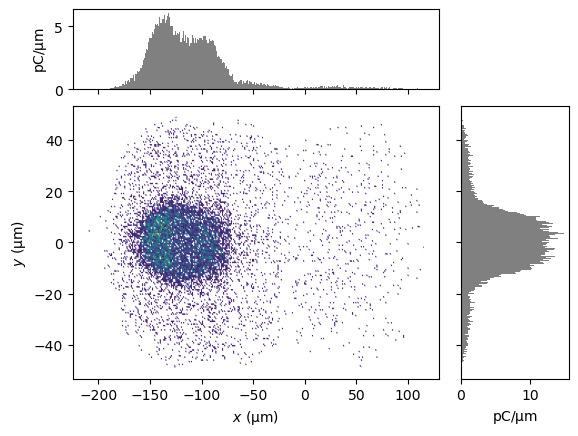

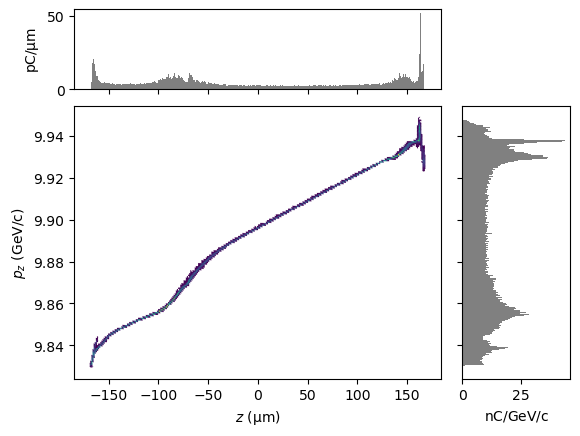

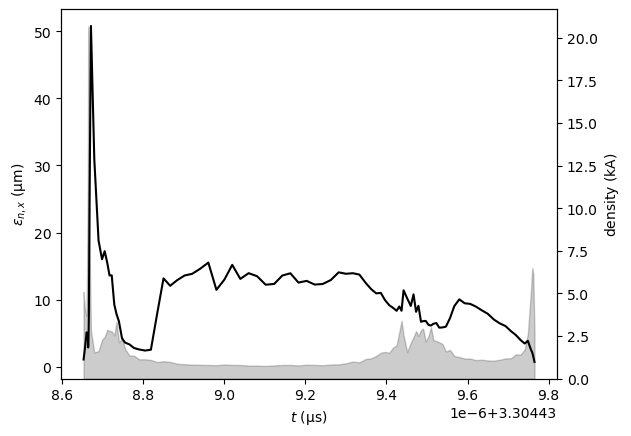

<Figure size 640x480 with 0 Axes>

In [7]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
print("Witness:")
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
#display(slicePlotMod(P, 'norm_emit_x', slice_key = "z", n_slice=100))
display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
plt.clf()

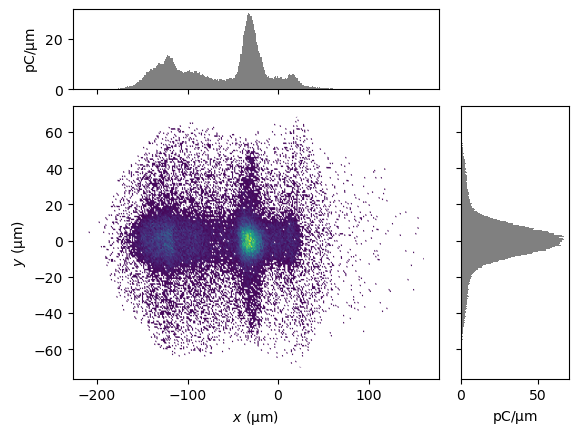

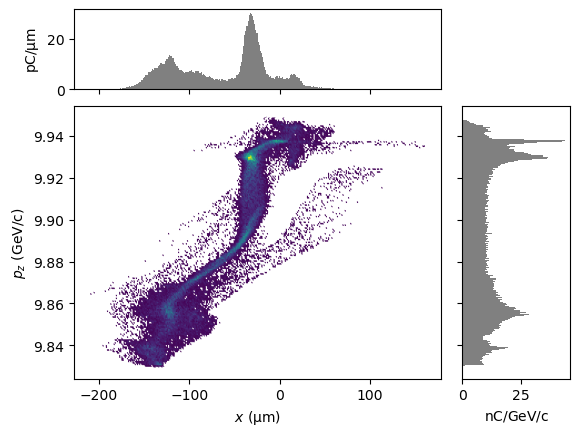

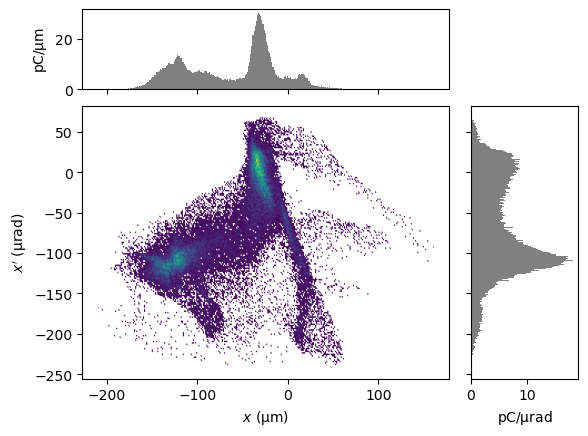

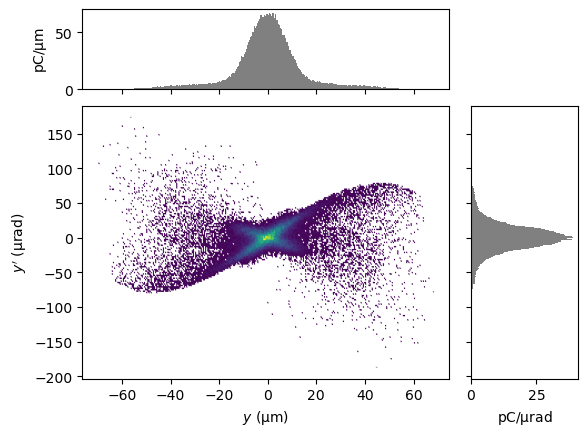

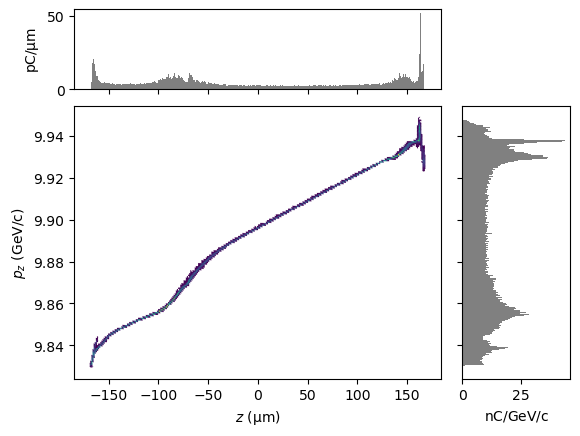

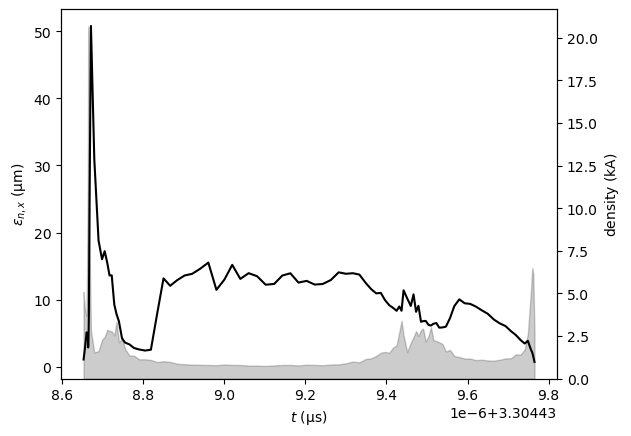

In [8]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))

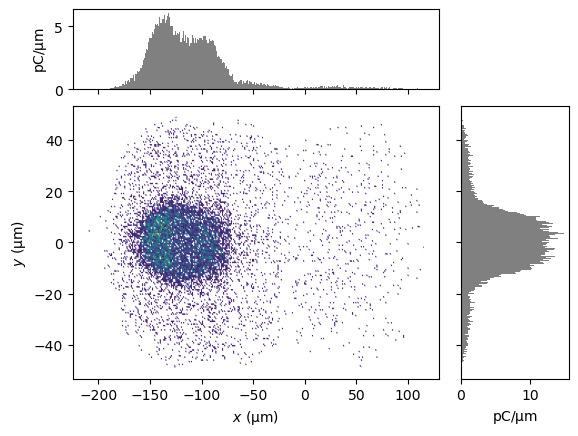

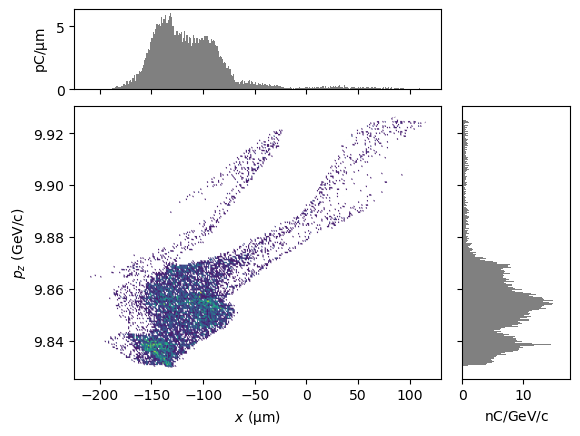

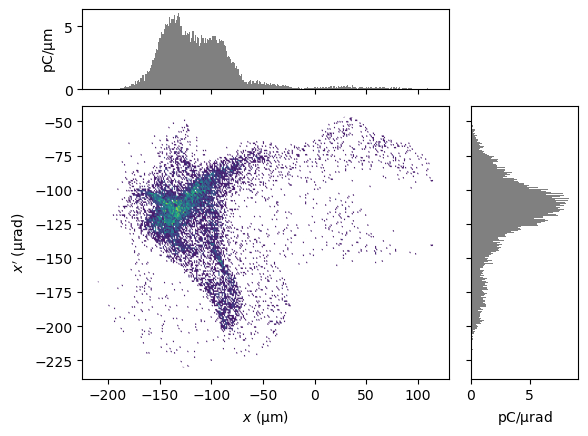

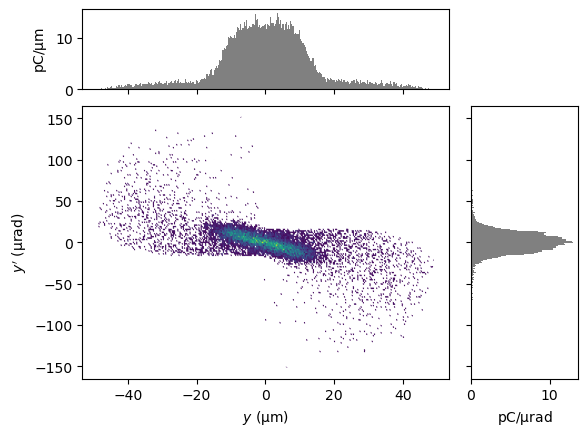

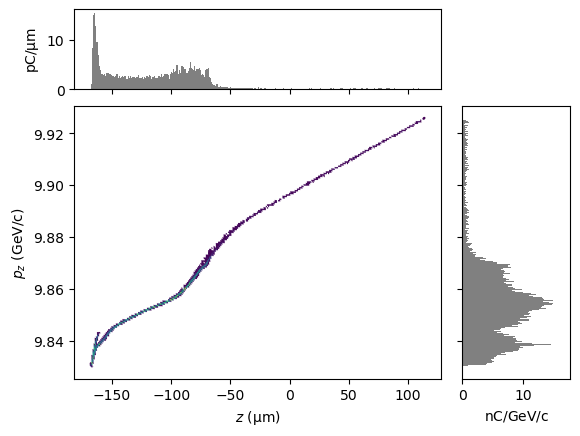

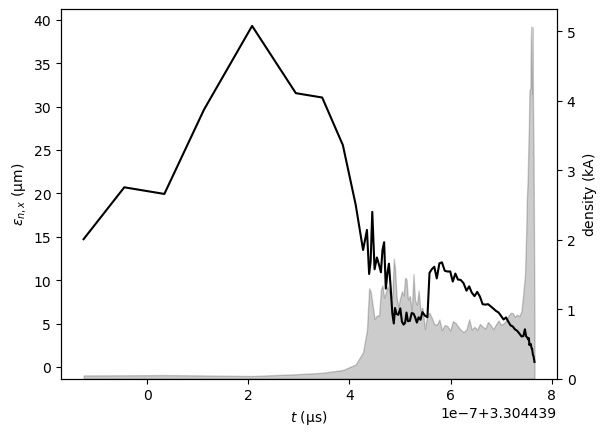

In [9]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'z', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


## Further study at other elements

In [10]:
?calcBMAG

Signature: calcBMAG(b0, a0, b, a)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [11]:
#def addBMAGToDict(dict, targetBeta, targetAlpha)

In [12]:
P = getBeamAtElement(tao, "PR10571")
PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.1262113469377621, 1.424390832454024
Drive BMAG:   1.2759520269514855, 1.7118633863143704
Witness BMAG: 3.495417073731863, 3.1104510452867453

System emit:  2.8699480746887173e-06, 2.8515111496890183e-06
Drive emit:   2.0225418494819615e-06, 2.1149938952283136e-06
Witness emit: 1.8119435226179993e-06, 1.8468089106489693e-06


In [13]:
P = getBeamAtElement(tao, "BEGBC20")
PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 6.121456284511682, 17.23371754110049
Drive alpha x / y: -0.7463558349915744, 1.3017225092092712

System BMAG:  1.6588206005607704, 1.0524598719093312
Drive BMAG:   2.3815768032915954, 1.3422538529923893
Witness BMAG: 1.1346732066834788, 1.8428477513976755

System emit:  8.294129985220206e-06, 2.8364636724479193e-06
Drive emit:   6.068317482289369e-06, 2.2396426161517647e-06
Witness emit: 7.524595799563585e-06, 1.8416033082045737e-06


In [14]:
P = getBeamAtElement(tao, "MFFF")
PDrive, PWitness = getDriverAndWitness(P)


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 12.950631226389294, 16.3503260746157
Drive alpha x / y: -1.3032413958839386, -0.5651422518839477

System BMAG:  1.0977350959492878, 1.0524649837579392
Drive BMAG:   1.1612959774235905, 1.2674304549911732
Witness BMAG: 1.9420117827194283, 2.2765900472907044

System emit:  1.4245038304284437e-05, 2.8502347984750297e-06
Drive emit:   1.3900687915318943e-05, 2.180685662436078e-06
Witness emit: 9.133860825561051e-06, 1.8243013558046044e-06


In [15]:
P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 0.5386697185869576, 0.6920589935816285
System alpha x / y: 0.2101739280766478, -0.5762262351679123
Drive beta x / y: 0.4067296362422374, 0.8340265326119772
Drive alpha x / y: 0.2578825001856793, -1.216663277208027
Witness beta x / y: 1.5708496770804388, 1.167142287705829
Witness alpha x / y: 0.3350705960039926, 0.9139505545196774
System BMAG:  1.0232770039111867, 1.1732450942065429
Drive BMAG:   1.0622654571350845, 1.5774889505098073
Witness BMAG: 1.7478673001756235, 1.5602617975203434

System emit:  1.4523198494060875e-05, 2.829856626080369e-06
Drive emit:   1.4436625445191063e-05, 2.280243478296747e-06
Witness emit: 9.074766105799137e-06, 1.8473179953302827e-06


# Comparing golden lattice to present lattice

In [16]:
# tao = initializeTao(loadDefaultLatticeTF=True)
# tao.cmd("show ele PENT")

In [17]:
# tao = initializeTao(loadDefaultLatticeTF=False)
# tao.cmd("show ele PENT")

In [18]:
# tao = initializeTao(loadDefaultLatticeTF=True)
# getMatrix(tao, "BEGBC20", "PENT", print = True);

# print()

# tao = initializeTao(loadDefaultLatticeTF=False)
# getMatrix(tao, "BEGBC20", "PENT", print = True);